In [1]:
from __future__ import print_function
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pandas as pd
import pickle
from scipy.optimize import curve_fit
from scipy import stats

topdir = os.path.dirname(os.path.abspath("__file__"))
analysis_dir = os.path.join(topdir,"analysis_root_files")
data_pklname = os.path.join(analysis_dir,"tempScanSiDetRun2.pkl")
SPE_pklname = os.path.join(analysis_dir,"tempScanSiDetRun2SPE.pkl")

with open(data_pklname, 'rb') as f:
    df = pickle.load(f)
df = df.query("VoverN >= 2.0").reset_index()

with open(SPE_pklname, 'rb') as f:
    df_SPE_clean = pickle.load(f)
    df_54V_Temp = pickle.load(f)
    df_55V_Temp = pickle.load(f)
    df_Vbd = pickle.load(f)

runs = df['run'].unique()
runs = np.sort(runs)
FEBs = df['FEB'].unique()
FEBs = np.sort(FEBs)
tempSetups = df['tempSetup'].unique()
tempSetups = np.sort(tempSetups)

bad_channels = [ 7, 10, 18, 19, 37]

def func_lin(x, k, b):
    return k*x+b

def func_quad(x, a, b, c):
    return a*x*x+b*x+c

def func_cubic(x, a, b, c, d):
    return a*x*x*x+b*x*x+c*x+d
   

For any given run, assume the LED photon emission per pulse is $\Phi$. The SiPM on the monitoring CMB0 has geometry factor $\lambda_0$. It is set at a constant voltage $V_{set,0}$. Its efficiency (quantum efficiency + crosstalk + other effects, which is really the ratio between the detected number of photons to the input) $\epsilon_0$ is a function of overvoltage $\epsilon_0(V_{over,0})$, which in turn is a function of temperature $T_0$, i.e., 
$$V_{over,0} = V_{set,0} - V_{bd}(T_0) = V_{set,0} - (U_{0}+kT_0)$$
Using the SPE values, the overvoltages can be calculated.\
Then in run j, the light yield on this SiPM on CMB0 is 
$$Y_{0, j} = \Phi_j \cdot \lambda_0 \cdot \epsilon_0(V_{set,0} - U_{0}-kT_{0,j})$$
Similarly for the SiPM i in the environment chamber, light yield 
$$Y_{i,j} = \Phi_j \cdot \lambda_i \cdot \epsilon_i(V_{set,i,j} - U_{i}-kT_{i,j})$$
In different runs, $\Phi_j$ can be different so we want to normalize and get rid of it:
$$\frac{Y_{i,j}}{Y_{0,j}} = \frac{\lambda_i \cdot \epsilon_i(V_{set,i,j} - U_{i}-kT_
{i,j})}{\lambda_0 \cdot \epsilon_0(V_{set,0} - U_{0}-kT_{0,j})}$$
Now considering runs $j_1$, $j_2$ taken at the same chamber temperature settings. From the slow control values we can safely approximate that $T_{0,j_1}=T_{0,j_2}$, and $T_{i,j_1}=T_{i,j_2}$. So the overvoltages are the same; $\epsilon_{0,j_1}=\epsilon_{0,j_2}$. (SiPM performance mainly dependent on overvoltage, except noise rate is a funciton of temperature, which is also the same anyways.)\
Thus if we take the ratio,
$$\frac{Y_{i,j_2}}{Y_{0,j_2}}/\frac{Y_{i,j_1}}{Y_{0,j_1}}=\frac{\epsilon_i(V_{set,i,j_2} - U_{i}-kT_{i,j})}{\epsilon_i(V_{set,i,j_1} - U_{i}-kT_{i,j})}$$
In other words, this gives relative light yield (efficiency) ratio at different overvoltages (since at the same temperature the runs scan through different set voltages). Results of different temperatures can be crosschecked.\
For practical purposes, since there are 4 channels used for monitoring and the light yields are different, relative light yields are calculated to a certain run, and $Y_{0,j}$ can be taken as the mean of the relative light yields for each run.

In [2]:
normatemp = 25
df_monitorPEs = df.query("ch < 4").reset_index(drop=True)
df_monitorRefPEs = df_monitorPEs.query("tempSetup==%i"%normatemp).reset_index(drop=True)
monitorRefPEs = []
for chan in range(4):
    df_ = df_monitorRefPEs.query("ch == %i"%chan).reset_index(drop=True)
    monitorRefPEs.append(np.mean(df_['PEs'].astype(float)))
monitorRefPEs = np.array(monitorRefPEs)
print("Monitor CMB, ~room temperature, Vbias = 54.5V")
print("Normalizing using scan runs at chamber temp. of %iC"%normatemp)
display(df_monitorRefPEs)
print(monitorRefPEs)

GetNormalization = lambda chan: monitorRefPEs[chan]
normalization_array = GetNormalization(df_monitorPEs['ch'])
df_monitorPEs.loc[:, 'PEs_normalized'] = np.divide(df_monitorPEs['PEs'], normalization_array)
print("Monitor CMB PEs")
with pd.option_context('display.max_rows', 10,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(df_monitorPEs)

df_PEsNormalizationFactorByRun = pd.DataFrame(columns=['run', 'norm_factor', 'norm_factor_rms', 'tempCMB'])
for run in runs:
    df_ = df_monitorPEs.query("run==%i"%(run)).reset_index(drop=True)
    norm_factors = df_['PEs_normalized']
    if norm_factors.size != 4:
        print("Run %i sees channel"%run, list(df_monitorPEs['ch']))
    new_row = {'run':run,
               'norm_factor':np.mean(norm_factors),
               'norm_factor_rms':np.std(norm_factors),
               'tempCMB':df_['CMBtemp'][0]}
    df_PEsNormalizationFactorByRun.loc[len(df_PEsNormalizationFactorByRun)] = new_row
print("Light yield normalization by run")
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(df_PEsNormalizationFactorByRun)

Monitor CMB, ~room temperature, Vbias = 54.5V
Normalizing using scan runs at chamber temp. of 25C


index   run  subrun  FEB  ch   pedestal    calibRaw    calibAdj  \
0      64  1828       0    0   0 -11.287900  377.442993  419.744995   
1      65  1828       0    0   1  17.132799  389.622009  431.809998   
2      66  1828       0    0   2   1.581220  396.470001  439.015015   
3      67  1828       0    0   3  -1.405860  388.385010  430.306000   
4     128  1829       0    0   0 -11.235000  376.625000  419.561005   
5     129  1829       0    0   1  17.024099  389.502991  432.148987   
6     130  1829       0    0   2   1.543210  395.863007  438.161011   
7     131  1829       0    0   3  -1.407410  387.260986  430.408997   
8     192  1830       0    0   0 -11.218400  377.018005  419.390015   
9     193  1830       0    0   1  17.198700  389.229004  431.526001   
10    194  1830       0    0   2   1.523140  395.494995  437.837006   
11    195  1830       0    0   3  -1.387730  387.135010  429.968994   
12    256  1831       0    0   0 -11.228500  377.455994  419.631989   
13    257  1831       0    0   1  17.261299  389.808990  432.130005   
14    258  1831       0    0   2   1.562190  396.330994  438.636993   
15    259  1831       0    0   3  -1.379060  387.071991  428.994995   
16    320  1832       0    0   0 -11.192600  376.838013  419.121002   
17    321  1832       0    0   1  17.143299  388.920990  431.639008   
18    322  1832       0    0   2   1.583160  395.467987  438.096985   
19    323  1832       0    0   3  -1.454980  387.445007  430.378998   
20    384  1833       0    0   0 -11.262100  376.802002  419.471008   
21    385  1833       0    0   1  17.063601  389.708008  431.700989   
22    386  1833       0    0   2   1.577370  395.868988  438.164001   
23    387  1833       0    0   3  -1.459530  387.773987  430.592987   
24    448  1834       0    0   0 -11.232000  376.424988  419.151001   
25    449  1834       0    0   1  17.134399  389.166992  431.763000   
26    450  1834       0    0   2   1.532870  394.955994  437.470001   
27    451  1834       0    0   3  -1.379770  386.865997  429.492004   
28    512  1835       0    0   0 -11.306600  377.269989  419.976990   
29    513  1835       0    0   1  17.129101  389.489014  432.054993   
30    514  1835       0    0   2   1.521780  395.673004  438.329987   
31    515  1835       0    0   3  -1.462690  388.485992  431.502991   
32    576  1836       0    0   0 -11.329200  377.339996  419.190002   
33    577  1836       0    0   1  17.118401  389.502014  431.398987   
34    578  1836       0    0   2   1.469130  394.893005  437.259003   
35    579  1836       0    0   3  -1.465670  388.239014  430.733002   

      FEBtemp    CMBtemp      biasV        PEs  PEsCorrected  VoverN  VppN  \
0      47.279  25.062500  54.266003  54.792221     58.081844     2.0  53.5   
1      47.279  25.062500  54.266003  63.499577     67.350792     2.0  53.5   
2      47.279  25.062500  54.266003  65.605774     69.518547     2.0  53.5   
3      47.279  25.062500  54.266003  54.548107     57.898975     2.0  53.5   
4   47.433334  25.062500  54.253338  54.887486     58.100155     2.5  54.0   
5   47.433334  25.062500  54.253338  63.445820     67.243401     2.5  54.0   
6   47.433334  25.062500  54.253338  65.715958     69.694725     2.5  54.0   
7   47.433334  25.062500  54.253338  54.678356     57.855827     2.5  54.0   
8       47.29  25.062500  54.259998  54.825008     58.118900     3.0  54.5   
9       47.29  25.062500  54.259998  63.485168     67.316406     3.0  54.5   
10      47.29  25.062500  54.259998  65.755905     69.715736     3.0  54.5   
11      47.29  25.062500  54.259998  54.681305     57.891624     3.0  54.5   
12  47.243332  25.062500  54.257782  54.740154     58.056503     3.5  55.0   
13  47.243332  25.062500  54.257782  63.362717     67.187813     3.5  55.0   
14  47.243332  25.062500  54.257782  65.559380     69.511246     3.5  55.0   
15  47.243332  25.062500  54.257782  54.694302     58.043060     3.5  55.0   
16   47.39333  25.062500  54.253338  54.830856    

[54.8328904  63.46573766 65.71485392 54.62379413]
Monitor CMB PEs


index   run  subrun  FEB  ch  pedestal  calibRaw  calibAdj    FEBtemp  \
0       64  1828       0    0   0   -11.288   377.443   419.745     47.279   
1       65  1828       0    0   1    17.133   389.622   431.810     47.279   
2       66  1828       0    0   2     1.581   396.470   439.015     47.279   
3       67  1828       0    0   3    -1.406   388.385   430.306     47.279   
4      128  1829       0    0   0   -11.235   376.625   419.561  47.433334   
..     ...   ...     ...  ...  ..       ...       ...       ...        ...   
391   6915  1935       0    0   3    -1.375   440.387   427.721   46.75889   
392   6976  1936       0    0   0   -11.125   431.000   418.574   46.90444   
393   6977  1936       0    0   1    17.247   443.070   430.370   46.90444   
394   6978  1936       0    0   2     1.713   451.735   438.650   46.90444   
395   6979  1936       0    0   3    -1.371   438.671   426.426   46.90444   

     CMBtemp   biasV     PEs  PEsCorrected  VoverN  VppN  tempSetup  \
0     25.062  54.266  54.792        58.082     2.0  53.5       25.0   
1     25.062  54.266  63.500        67.351     2.0  53.5       25.0   
2     25.062  54.266  65.606        69.519     2.0  53.5       25.0   
3     25.062  54.266  54.548        57.899     2.0  53.5       25.0   
4     25.062  54.253  54.887        58.100     2.5  54.0       25.0   
..       ...     ...     ...           ...     ...   ...        ...   
391   17.250  54.227  58.924        56.583     5.5  55.1      -10.0   
392   17.250  54.258  59.656        57.268     6.0  55.6      -10.0   
393   17.250  54.258  68.839        66.122     6.0  55.6      -10.0   
394   17.250  54.258  70.465        67.741     6.0  55.6      -10.0   
395   17.250  54.258  59.142        56.757     6.0  55.6      -10.0   

     tempSensor  PEs_normalized  
0          25.0           0.999  
1          25.0           1.001  
2          25.0           0.998  
3          25.0           0.999  
4          25.0           1.001  
..          ...             ...  
391        -9.4           1.079  
392        -9.4           1.088  
393        -9.4           1.085  
394        -9.4           1.072  
395        -9.4           1.083  

[396 rows x 18 columns]

Light yield normalization by run


run  norm_factor  norm_factor_rms  tempCMB
0   1828        0.999        8.459e-04   25.062
1   1829        1.000        5.847e-04   25.062
2   1830        1.000        4.378e-04   25.062
3   1831        0.999        1.409e-03   25.062
4   1832        1.000        5.555e-04   25.062
5   1833        0.999        6.933e-04   25.062
6   1834        1.001        6.233e-04   25.116
7   1835        1.000        6.747e-04   25.125
8   1836        1.001        1.530e-03   25.062
9   1838        0.989        1.545e-03   26.375
10  1839        0.988        2.178e-03   26.375
11  1840        0.989        2.363e-03   26.375
12  1841        0.989        2.229e-03   26.375
13  1842        0.988        2.871e-03   26.323
14  1843        0.988        2.313e-03   26.333
15  1844        0.988        6.177e-04   26.319
16  1845        0.990        2.000e-03   26.312
17  1846        0.988        1.557e-03   26.328
18  1848        0.973        1.968e-03   27.750
19  1849        0.974        2.053e-03   27.750
20  1850        0.973        1.831e-03   27.756
21  1851        0.974        2.902e-03   27.771
22  1852        0.972        2.551e-03   27.797
23  1853        0.974        2.317e-03   27.760
24  1854        0.976        3.272e-03   27.750
25  1855        0.974        3.126e-03   27.750
26  1856        0.973        2.122e-03   27.750
27  1858        0.963        5.088e-03   28.812
28  1859        0.963        2.933e-03   28.771
29  1860        0.962        3.102e-03   28.769
30  1861        0.966        4.285e-03   28.750
31  1862        0.964        4.811e-03   28.750
32  1863        0.966        2.543e-03   28.725
33  1864        0.963        5.006e-03   28.688
34  1865        0.964        3.369e-03   28.698
35  1866        0.964        2.897e-03   28.688
36  1868        1.017        2.022e-03   23.948
37  1869        1.015        2.062e-03   24.000
38  1870        1.015        2.020e-03   24.000
39  1871        1.015        2.078e-03   24.000
40  1872        1.018        1.200e-03   24.000
41  1873        1.016        8.846e-04   24.000
42  1874        1.015        8.599e-04   24.016
43  1875        1.014        1.413e-03   24.025
44  1876        1.016        1.085e-03   24.000
45  1878        1.031        1.373e-03   22.625
46  1879        1.030        8.891e-04   22.625
47  1880        1.030        2.322e-03   22.625
48  1881        1.031        1.986e-03   22.625
49  1882        1.029        1.820e-03   22.625
50  1883        1.031        1.959e-03   22.625
51  1884        1.030        3.637e-03   22.625
52  1885        1.032        2.106e-03   22.625
53  1886        1.030        1.100e-03   22.625
54  1888        1.042        1.876e-03   21.525
55  1889        1.041        3.799e-03   21.500
56  1890        1.043        3.731e-03   21.500
57  1891        1.043        4.237e-03   21.500
58  1892        1.042        1.831e-03   21.500
59  1893        1.044        2.763e-03   21.469
60  1894        1.045        2.872e-03   21.458
61  1895        1.043        2.001e-03   21.469
62  1896        1.044        2.615e-03   21.446
63  1898        1.052        3.101e-03   20.438
64  1899        1.053        3.405e-03   20.438
65  1900        1.054        3.258e-03   20.438
66  1901        1.053        3.036e-03   20.438
67  1902        1.052        3.297e-03   20.438
68  1903        1.054        4.602e-03   20.417
69  1904        1.053        2.169e-03   20.375
70  1905        1.052        3.813e-03   20.420
71  1906        1.053        3.600e-03   20.384
72  1908        1.065        3.628e-03   19.312
73  1909        1.062        3.105e-03   19.312
74  1910        1.064        3.849e-03   19.312
75  1911        1.063        2.114e-03   19.312
76  1912        1.062        4.452e-03   19.312
77  1913        1.064        3.952e-03   19.273
78  1914        1.064        4.204e-03   19.275
79  1915        1.065        4.865e-03   19.289
80  1916        1.063        4.305e-03   19.263
81  1918        1.075        4.347e-03   18.139
82  1919        1.075

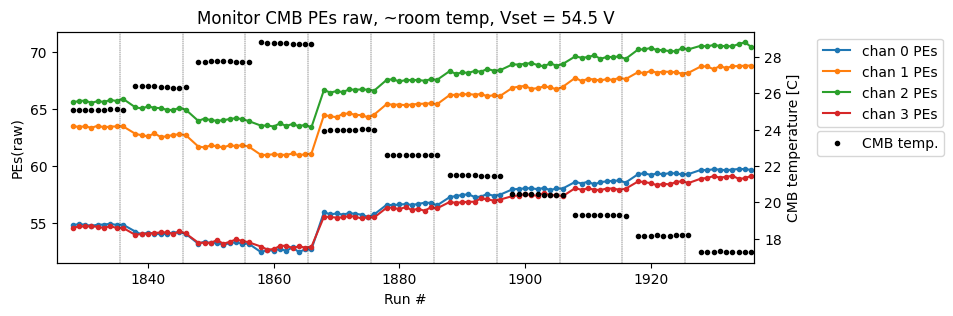

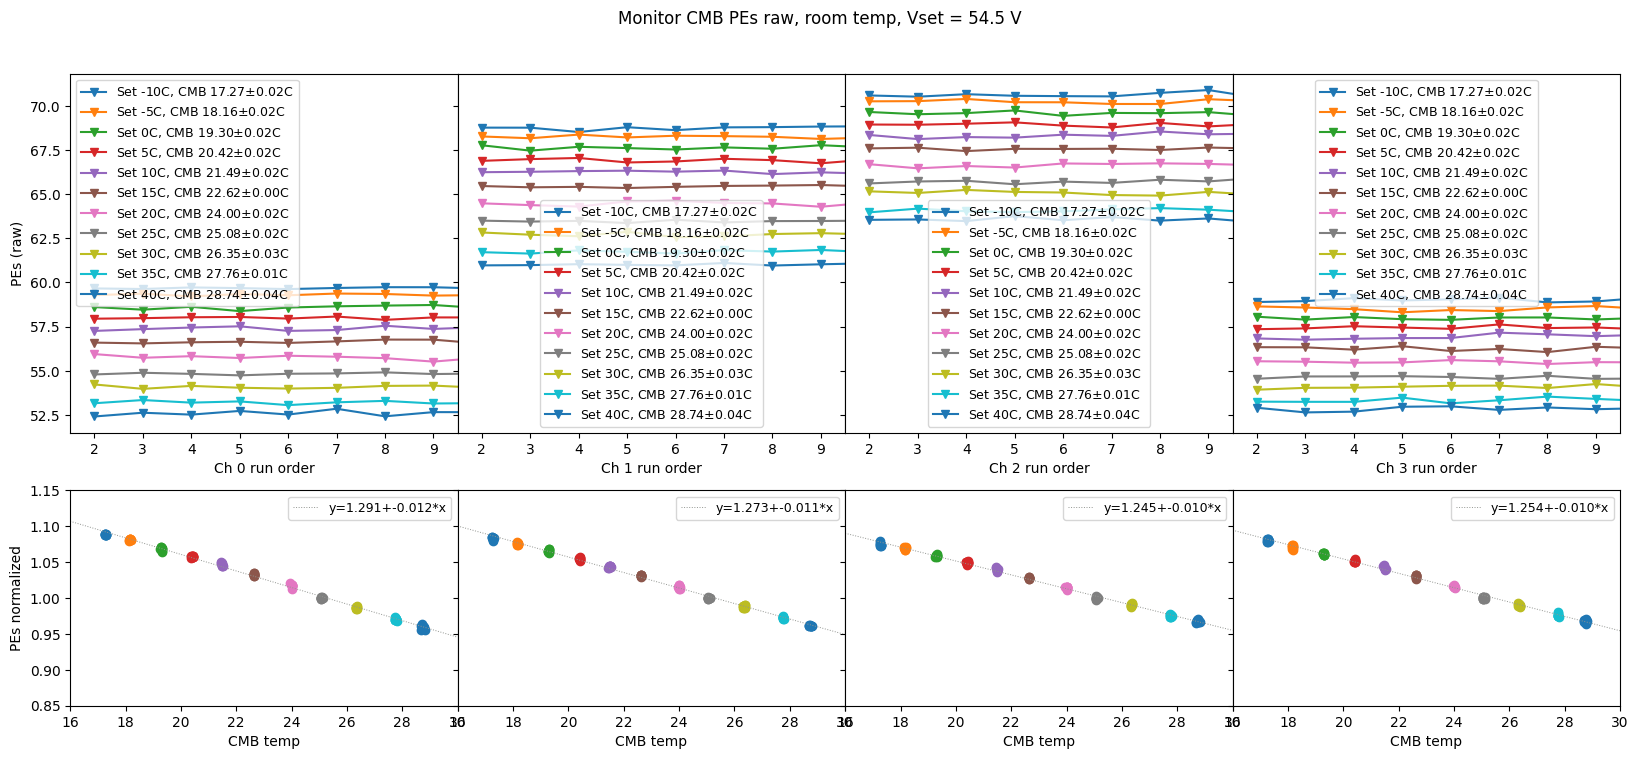

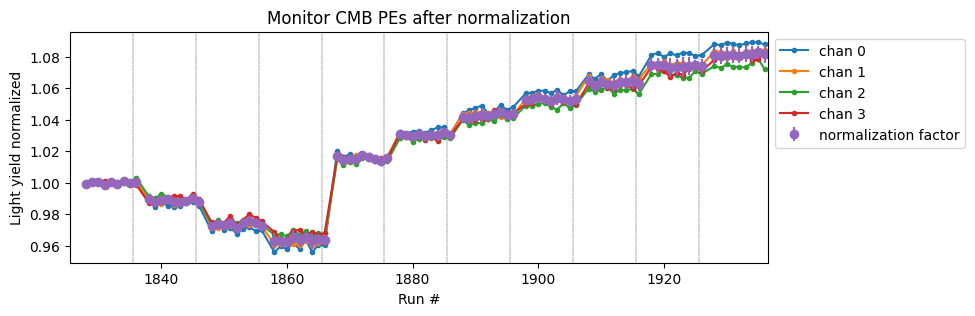

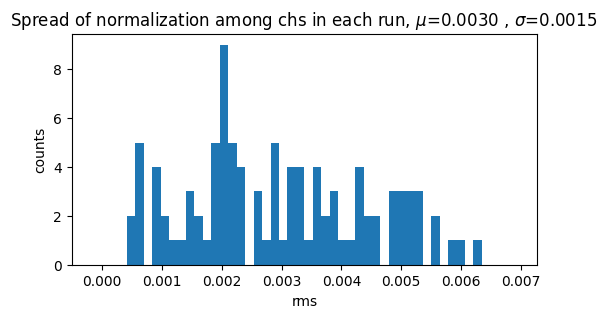

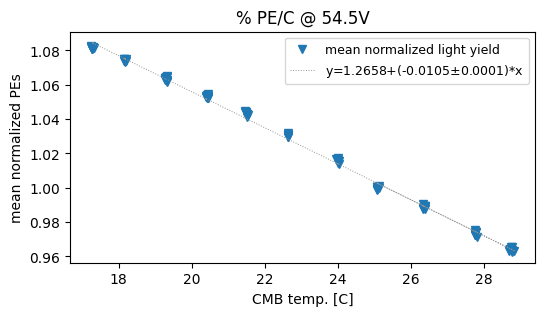

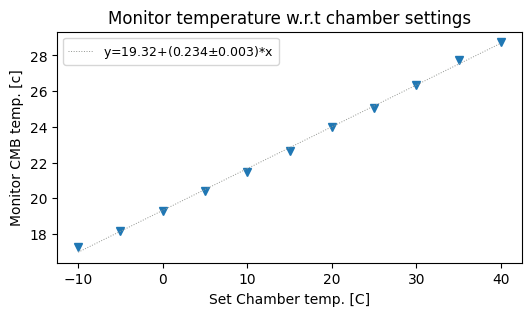

In [3]:
# raw PEs
plt.figure(figsize = (9,3))
for chan in range(4):
    df_ = df_monitorPEs.query('ch == %i'%chan)
    plt.plot(df_['run'], df_['PEs'],'.-',
             label='chan %i PEs'%chan)
plt.title("Monitor CMB PEs raw, ~room temp, Vset = 54.5 V")
plt.xlabel("Run #")
plt.ylabel("PEs(raw)")
plt.gca().set_xlim(np.min(runs)-2.5, np.max(runs)+0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1.08, 1.0))
ax2 = plt.gca().twinx()
ax2.plot(df_['run'], df_['CMBtemp'],'.', color='k', linestyle='none', label='CMB temp.')
ax2.set_ylabel("CMB temperature [C]")
plt.legend(loc='upper left', bbox_to_anchor=(1.08, 0.6))
for iTemp in range(11):
    plt.axvline(x=np.min(runs)+10*iTemp-2.5, color='k', linestyle='--', linewidth=0.3)
plt.show()

# grid
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8), sharey='row',
                        gridspec_kw={'width_ratios':[5 for i in range(4)],
                                     'height_ratios':[5,3]})
fig.suptitle("Monitor CMB PEs raw, room temp, Vset = 54.5 V")
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.9)
axs[0, 0].set_ylabel("PEs (raw)")
axs[1, 0].set_ylabel("PEs normalized")
for chan in range(4):
    axs[0, chan].set_xlabel('Ch %i run order'%chan)
    axs[1, chan].set_xlabel('CMB temp')
for chan in range(4):
    for tTempSetup in tempSetups:
        df_ = df_monitorPEs.query("ch==%i & tempSetup==%i"%(chan, tTempSetup)).reset_index()
        xx = df_['run'].astype(int)
        xx = xx % (np.min(xx)-2)
        yy = df_['PEs'].astype(float)
        meanTemp = np.mean(df_['CMBtemp'].astype(float))
        stdTemp = np.std(df_['CMBtemp'].astype(float))
        
        tscatter = axs[0, chan].plot(xx, yy, 'v-', label=r'Set %.0fC, CMB %.2f$\pm$%.2fC'%(tTempSetup, meanTemp, stdTemp))
        axs[0, chan].set_xlim(1.5,9.5)
        axs[1, chan].plot(df_['CMBtemp'].astype(float), df_['PEs_normalized'].astype(float), 
                          'o', color = tscatter[0].get_color(), linestyle='none')
        axs[1, chan].set_xlim(16.,30.)
        axs[1, chan].set_ylim(0.85,1.15)

    df_ = df_monitorPEs.query("ch==%i"%(chan)).reset_index()
    popt, pcov = curve_fit(func_lin, df_['CMBtemp'].astype(float), df_['PEs_normalized'].astype(float))
    slope = popt[0]
    intercept = popt[1]
    std_err = np.sqrt(pcov[0,0])
    intercept_stderr = np.sqrt(pcov[1,1])
    xx = np.array(list(range(16,32,2)))
    axs[1, chan].plot(xx, slope * xx + intercept, ':', color = '#929591', linewidth=0.7,
                      label='y=%.3f+%.3f*x'%(intercept, slope))

    axs[0, chan].legend(fontsize=9)
    axs[1, chan].legend(fontsize=9)
plt.show()

# normalized light yields
plt.figure(figsize = (9,3))
for chan in range(4):
    df_ = df_monitorPEs.query('ch == %i'%chan)
    plt.plot(df_['run'], df_['PEs_normalized'],'.-',
             label='chan %i'%chan)
plt.errorbar(df_PEsNormalizationFactorByRun['run'], df_PEsNormalizationFactorByRun['norm_factor'],
             yerr = df_PEsNormalizationFactorByRun['norm_factor_rms'],
             marker = 'o', linestyle='none',
             label='normalization factor')
plt.title("Monitor CMB PEs after normalization")
plt.xlabel("Run #")
plt.ylabel("Light yield normalized")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
for iTemp in range(11):
    plt.axvline(x=np.min(runs)+10*iTemp-2.5, color='k', linestyle='--', linewidth=0.3)
plt.gca().set_xlim(np.min(runs)-2.5, np.max(runs)+0.5)
plt.show()

# spread of normalization in each run among chs
vals = df_PEsNormalizationFactorByRun['norm_factor_rms'].astype(float)
plt.figure(figsize = (6,3))
rangemin = np.min(vals)
rangemax = np.max(vals)
span = rangemax-rangemin
nbins = 50
step = span*1.2/nbins
plt.hist(vals,[rangemin-0.1*span+step*float(i) for i in range(nbins+1)])
plt.title("Spread of normalization among chs in each run, "+r'$\mu$'+"=%.4f "%(np.mean(vals))+r', $\sigma$'+"=%.4f "%(np.std(vals)))
plt.xlabel("rms")
plt.ylabel("counts")
plt.show()

#factor vs temp.
plt.figure(figsize = (6,3))
xx = df_PEsNormalizationFactorByRun['tempCMB'].astype(float)
yy = df_PEsNormalizationFactorByRun['norm_factor'].astype(float)
plt.plot(xx, yy, 'v', linestyle='none', label = 'mean normalized light yield')
popt, pcov = curve_fit(func_lin, xx, yy)
slope = popt[0]
intercept = popt[1]
std_err = np.sqrt(pcov[0,0])
intercept_stderr = np.sqrt(pcov[1,1])
plt.plot(xx, slope * xx + intercept, ':', color = '#929591', linewidth=0.7, label='y=%.4f+(%.4f$\pm$%.4f)*x'%(intercept, slope, std_err))
plt.legend(fontsize=9)
plt.title("% PE/C @ 54.5V")
plt.xlabel("CMB temp. [C]")
plt.ylabel("mean normalized PEs")
plt.show()

#temp vs set temp
CMBtemps = []
for tTempSetup in tempSetups:
    df_ = df_monitorPEs.query("ch==0 & tempSetup==%i"%(tTempSetup)).reset_index()
    meanTemp = np.mean(df_['CMBtemp'].astype(float))
    CMBtemps.append(meanTemp)
CMBtemps = np.array(CMBtemps)
plt.figure(figsize = (6,3))
plt.plot(tempSetups, CMBtemps, 'v', linestyle='none')
popt, pcov = curve_fit(func_lin, tempSetups, CMBtemps)
slope = popt[0]
intercept = popt[1]
std_err = np.sqrt(pcov[0,0])
intercept_stderr = np.sqrt(pcov[1,1])
plt.plot(tempSetups, slope * tempSetups + intercept, ':', color = '#929591', linewidth=0.7, label='y=%.2f+(%.3f$\pm$%.3f)*x'%(intercept, slope, std_err))
plt.legend(fontsize=9)
plt.title("Monitor temperature w.r.t chamber settings")
plt.xlabel("Set Chamber temp. [C]")
plt.ylabel("Monitor CMB temp. [c]")
plt.show()


Quantum efficiency w.r.t overvoltage and overvoltage w.r.t temperature can be slightly different for different channels. As light yield is determined to within 1%, slight divergence in PEs_normalized is acceptable as shown.\
-1.05%/C at 54.5V is consistent with the previous analysis (-1.3%/C @ 54V and -1.0%/C @ 55V). But this value contains both SiPM temperature effect and LED temperature effect.

In [4]:
# Get overvoltage of each run, as well as PEs/Y0
Vover = []
PEsByY0 = []
df_scan = df.query("ch >= 8").reset_index(drop=True)
for index, row in df_scan.iterrows():
    if row['ch'] in bad_channels:
        Vover.append(0)
        PEsByY0.append(0)
    else:
        tChan = row['ch']
        df_Vbd_ = df_Vbd.query("chan == %i"%tChan).reset_index()
        VbdPerC = df_Vbd_['slope'][0]/1000.
        VbdIntercept = df_Vbd_['intercept'][0]
        tTemp = row['CMBtemp']
        tVppN = row['VppN']
        Vover.append(tVppN - (VbdPerC*tTemp+VbdIntercept))
        tRun = row['run']
        tY0 = df_PEsNormalizationFactorByRun.query("run == %i"%tRun).reset_index()['norm_factor'][0]
        PEsByY0.append(row['PEs']/tY0)
# print(Vover)
# print(PEsByY0)
df_scan.loc[:, 'Vover'] = np.array(Vover)
df_scan.loc[:, 'PEsByY0'] = np.array(PEsByY0)

with pd.option_context('display.max_rows', 10,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(df_scan)

index   run  subrun  FEB  ch  pedestal  calibRaw  calibAdj   FEBtemp  \
0        72  1828       0    0   8    -2.813   255.035   299.555    47.279   
1        73  1828       0    0   9    -7.282   262.937   308.579    47.279   
2        74  1828       0    0  10     0.627   285.318   236.949    47.279   
3        75  1828       0    0  11   -19.078   254.747   300.219    47.279   
4        76  1828       0    0  12   -12.373   256.918   301.505    47.279   
...     ...   ...     ...  ...  ..       ...       ...       ...       ...   
5539   7035  1936       0    0  59    -7.444   760.974   564.222  46.90444   
5540   7036  1936       0    0  60    -8.315   750.844   554.073  46.90444   
5541   7037  1936       0    0  61    -4.553   777.971   582.442  46.90444   
5542   7038  1936       0    0  62     2.200   757.938   563.072  46.90444   
5543   7039  1936       0    0  63     8.213   745.764   549.612  46.90444   

      CMBtemp   biasV     PEs  PEsCorrected  VoverN  VppN  tempSetup  \
0      25.438  53.626   0.000         0.000     2.0  53.5       25.0   
1      25.438  53.626   0.000         0.000     2.0  53.5       25.0   
2      25.438  53.626   0.000         0.000     2.0  53.5       25.0   
3      25.438  53.626   0.000         0.000     2.0  53.5       25.0   
4      25.487  53.626  34.878        37.287     2.0  53.5       25.0   
...       ...     ...     ...           ...     ...   ...        ...   
5539   -9.031  55.582  68.456        49.892     6.0  55.6      -10.0   
5540   -9.125  55.582  75.550        54.972     6.0  55.6      -10.0   
5541   -9.125  55.582  67.935        49.338     6.0  55.6      -10.0   
5542   -9.125  55.582  61.119        44.344     6.0  55.6      -10.0   
5543   -9.125  55.582  52.105        37.866     6.0  55.6      -10.0   

      tempSensor  Vover  PEsByY0  
0           25.0  2.089    0.000  
1           25.0  2.128    0.000  
2           25.0  0.000    0.000  
3           25.0  2.121    0.000  
4           25.0  2.092   34.906  
...          ...    ...      ...  
5539        -9.4  6.042   63.274  
5540        -9.4  6.074   69.830  
5541        -9.4  6.131   62.792  
5542        -9.4  6.070   56.492  
5543        -9.4  6.021   48.161  

[5544 rows x 19 columns]

0PE channel: 10 at set temp 5 C
0PE channel: 19 at set temp 5 C
0PE channel: 19 at set temp 25 C
0PE channel: 19 at set temp 30 C
0PE channel: 19 at set temp 40 C
0PE channel: 37 at set temp 25 C
0PE channel: 37 at set temp 35 C


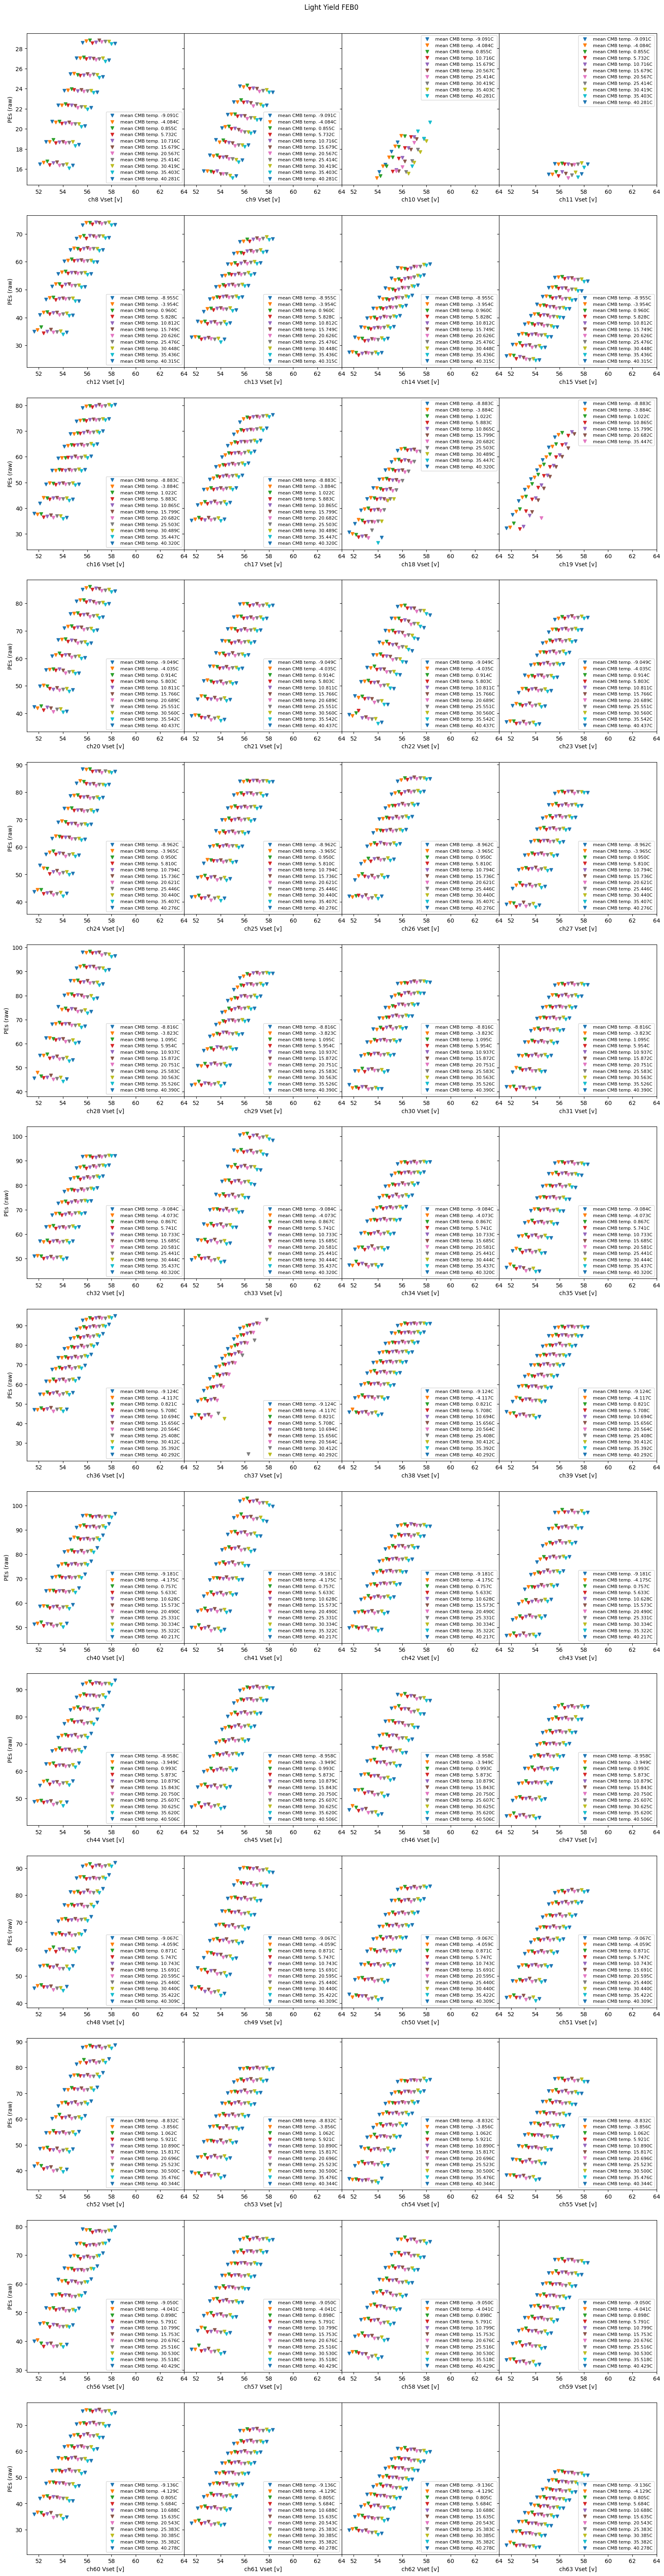

In [5]:
nr = 14
nc = 4

# grid of raw light yield
maintitle = 'Light Yield'
fig, axs = plt.subplots(nrows = nr, ncols = nc, figsize = (5*nc, 5*nr/0.97), sharey = 'row')
plt.suptitle(maintitle+" FEB0")
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.97)
ytitle = 'PEs (raw)'
xtitle = 'Vset [v]'
for index, ax in enumerate(axs.flatten()):
    chan = index + 8
    ax.set_xlabel('ch%i '%chan+xtitle)
    if (index%4 == 0):
        ax.set_ylabel(ytitle)
    # if chan in bad_channels:
        # continue
    emptyFlag = True
    for tTempSetup in tempSetups:
        df_ = df_scan.query("ch==%i & tempSetup==%f"%(chan, tTempSetup)).reset_index()
        xx = df_['VppN'].astype(float)
        yy = df_['PEs'].astype(float)

        # if chan in [36,37,38,39]:
            # print(chan, tTempSetup, yy[yy<50])
            
        meanTemp = np.mean(df_['CMBtemp'].astype(float))
        mask = (yy>0)
        xx=xx[mask]
        yy=yy[mask]
        if yy.size==0:
            print("0PE channel: %d at set temp %.0f C"%(chan, tTempSetup))
            continue
        if True: #xx.size>3:
            emptyFlag = False
            #tscatter = ax.plot(xx, yy, 'v', label='Set temp. %.0fC, mean CMB temp. %.3fC'%(tTempSetup, meanTemp))
            tscatter = ax.plot(xx, yy, 'v', label='mean CMB temp. %.3fC'%(meanTemp))
            ax.set_xlim(51.,64.)
            # axs.set_ylim(20.,80.)
    if not emptyFlag:
        ax.legend(fontsize=8)
plt.show()

Cannot interpolate channel 11 at set temp -10 C
[5.624456478094324, 6.124025914790693]
Cannot interpolate channel 11 at set temp -5 C
[5.6467431472526215, 6.149757090378031]
Cannot interpolate channel 11 at set temp 0 C
[5.676349392572639, 6.174627139358115]
Cannot interpolate channel 11 at set temp 5 C
[5.606939778832448, 6.106447721502299]
Cannot interpolate channel 11 at set temp 10 C
[5.633150739224142, 6.131871348118551]
Cannot interpolate channel 11 at set temp 15 C
[5.6587096789782265, 6.1582791156745955]
Cannot interpolate channel 11 at set temp 20 C
[5.588229832661121, 6.088918670876133]
Cannot interpolate channel 11 at set temp 25 C
[5.622849680707368, 6.122467051209021]
Cannot interpolate channel 11 at set temp 30 C
[5.647442323301142, 6.145375598420117]
Cannot interpolate channel 11 at set temp 35 C
[5.572915223977105, 6.071192970762581]
Cannot interpolate channel 11 at set temp 40 C
[5.603439990329136, 6.101717737114612]


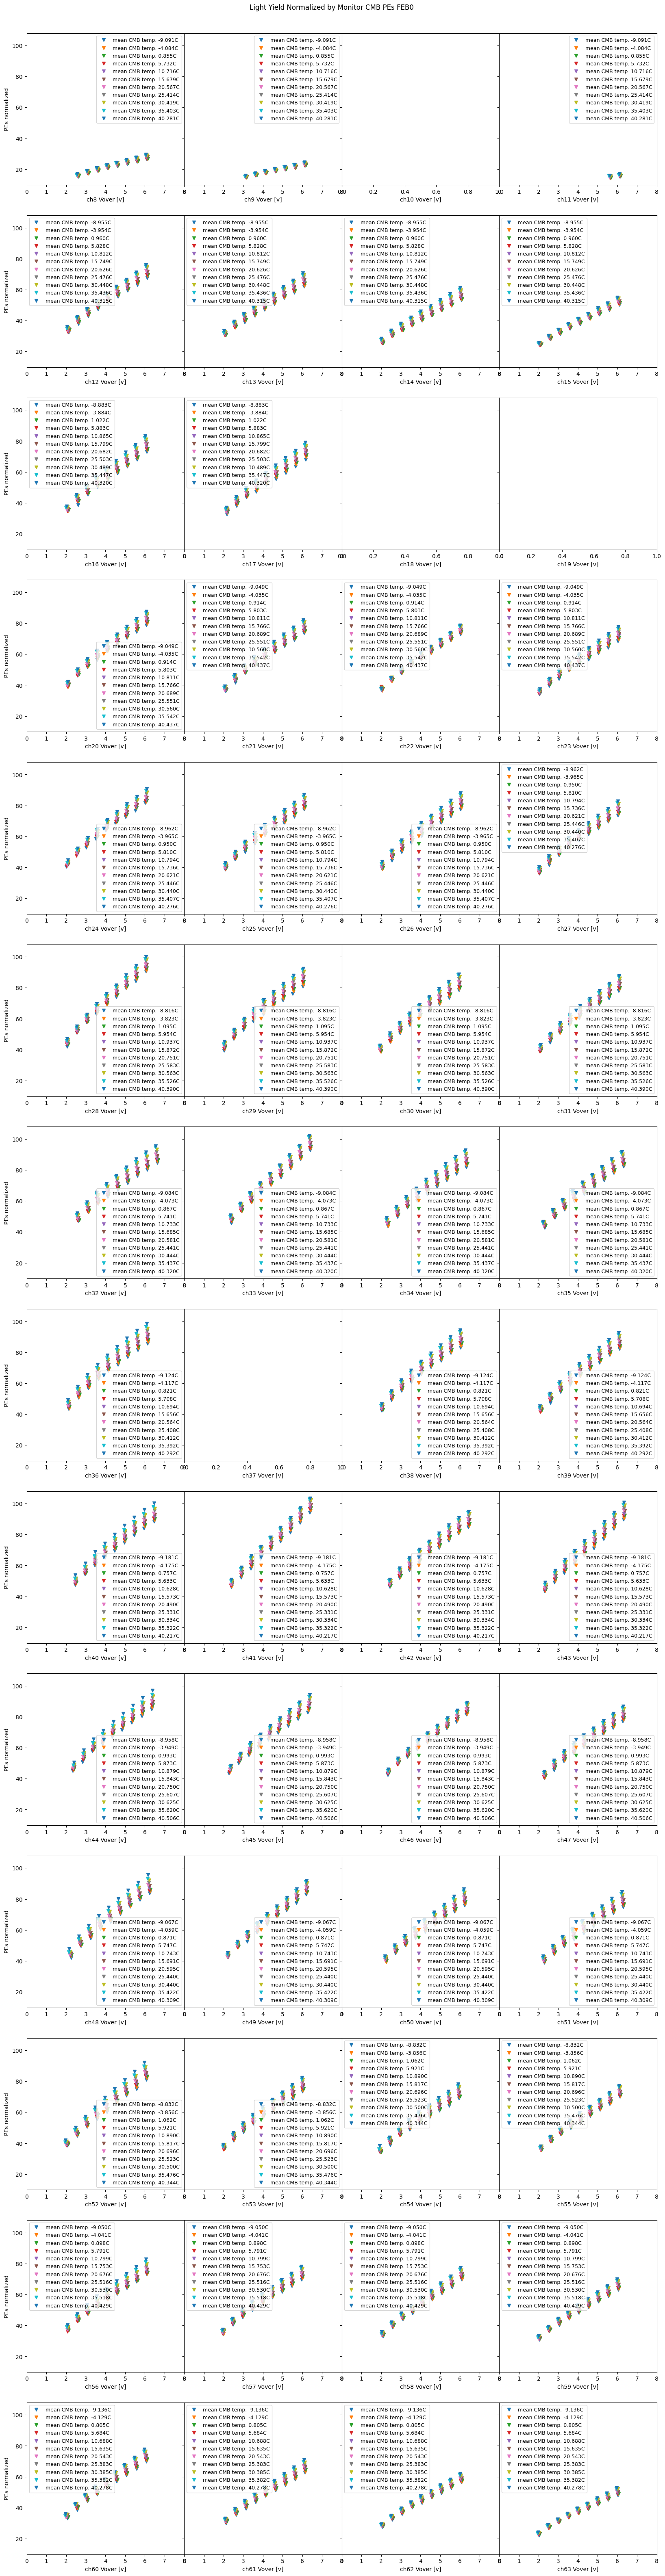

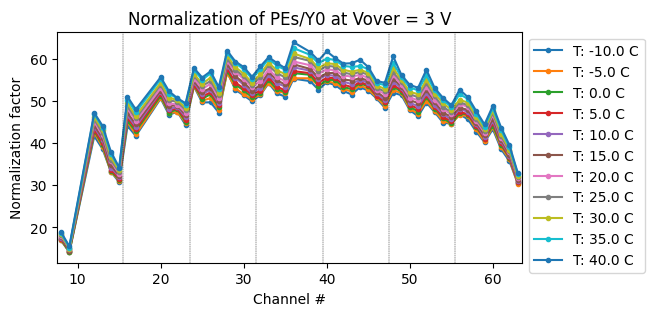

In [6]:
# grid of Yij/Y0j vs Vover
normalization_Vover = 3
df_normalizationAt3VVover = pd.DataFrame(columns=['ch', 'tempSetup', 'normalization'])

maintitle = 'Light Yield Normalized by Monitor CMB PEs'
fig, axs = plt.subplots(nrows = nr, ncols = nc, figsize = (5*nc, 5*nr/0.97), sharey = True)
plt.suptitle(maintitle+" FEB0")
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.97)
ytitle = 'PEs normalized'
xtitle = 'Vover [v]'
for index, ax in enumerate(axs.flatten()):
    chan = index + 8
    ax.set_xlabel('ch%i '%chan+xtitle)
    if (index%4 == 0):
        ax.set_ylabel(ytitle)
    if chan in bad_channels:
        continue
    emptyFlag = True
    for tTempSetup in tempSetups:
        df_ = df_scan.query("ch==%i & tempSetup==%f"%(chan, tTempSetup)).reset_index()
        xx = df_['Vover'].astype(float)
        yy = df_['PEsByY0'].astype(float)
        meanTemp = np.mean(df_['CMBtemp'].astype(float))
        mask = (yy>0)
        xx=xx[mask]
        yy=yy[mask]
        if yy.size==0:
            print("0PE channel: %d at set temp %.0f C"%(chan, tTempSetup))
            continue
        if True: #xx.size>3:
            emptyFlag = False
            tscatter = ax.plot(xx, yy, 'v', label='mean CMB temp. %.3fC'%(meanTemp))
            ax.set_xlim(0.,8.)
            # axs.set_ylim(20.,80.)
        if xx.size>3 and np.min(xx)<=3.5 and np.max(xx)>=2.5:
            #popt, pcov = curve_fit(func_quad, xx.astype(float), yy.astype(float))
            #tNormalization = popt[0]*3*3 + popt[1]*3 + popt[2]
            popt, pcov = curve_fit(func_cubic, xx.astype(float), yy.astype(float))
            tNormalization = popt[0]*3*3*3 + popt[1]*3*3 + popt[2]*3 + popt[3]
            new_row = {'ch':chan, 
                       'tempSetup':tTempSetup, 
                       'normalization':tNormalization}
            df_normalizationAt3VVover.loc[len(df_normalizationAt3VVover)] = new_row            
        else:
            print("Cannot interpolate channel %d at set temp %.0f C"%(chan, tTempSetup))
            print(list(xx))
            new_row = {'ch':chan, 
                       'tempSetup':tTempSetup, 
                       'normalization':0.0}
            df_normalizationAt3VVover.loc[len(df_normalizationAt3VVover)] = new_row      
    if not emptyFlag:
        ax.legend(fontsize=9)
plt.show()

plt.figure(figsize = (6,3))
for temp in tempSetups:
    df_ = df_normalizationAt3VVover.query('tempSetup==%f & normalization>0'%temp)
    plt.plot(df_['ch'], df_['normalization'],'.-',
                 label='T: %.1f C'%temp)
plt.title("Normalization of PEs/Y0 at Vover = 3 V")
plt.xlabel("Channel #")
plt.ylabel("Normalization factor")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
for iAFE in range(1, 8):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(7.5, 63+0.5)
plt.show()

From the formulae, we can see the deviations in the above plot is independent of the LED light yield, but still affected by the efficiency differences on the monitoring SiPMs due to temperature changes / geometry of test stand.

Bad normalization channel: 11 at set temp -10 C
Bad normalization channel: 11 at set temp -5 C
Bad normalization channel: 11 at set temp 0 C
Bad normalization channel: 11 at set temp 5 C
Bad normalization channel: 11 at set temp 10 C
Bad normalization channel: 11 at set temp 15 C
Bad normalization channel: 11 at set temp 20 C
Bad normalization channel: 11 at set temp 25 C
Bad normalization channel: 11 at set temp 30 C
Bad normalization channel: 11 at set temp 35 C
Bad normalization channel: 11 at set temp 40 C


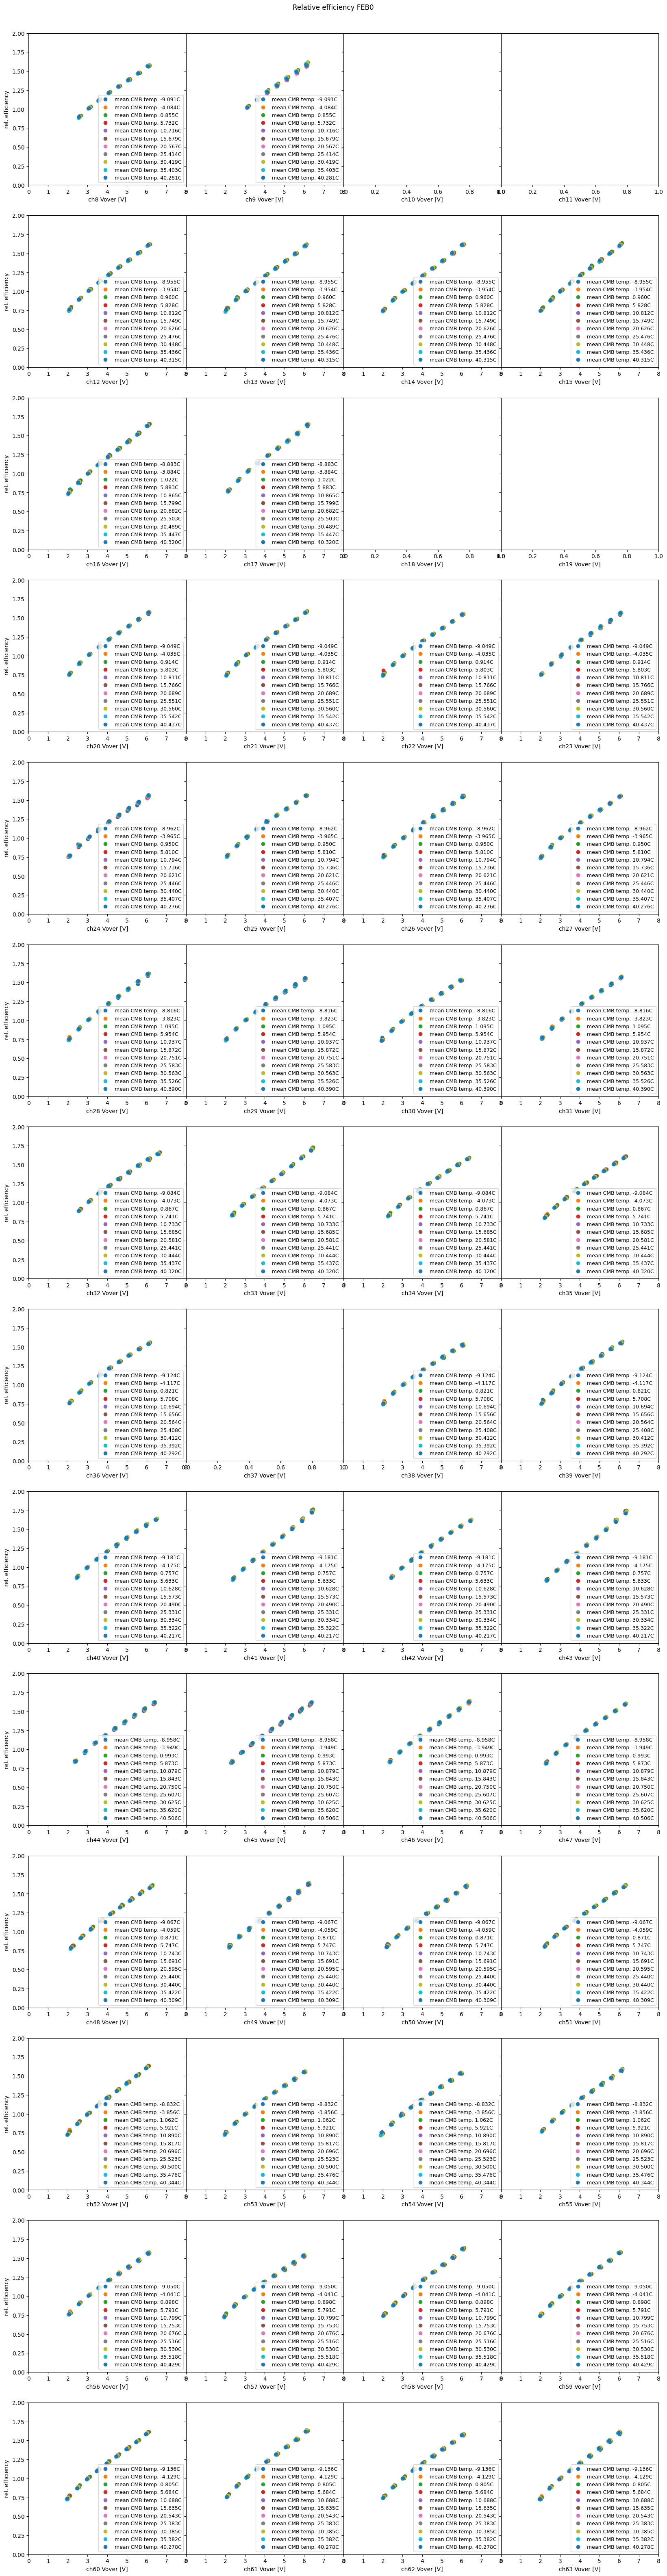

In [7]:
# grid normalized to 1 at 3 V overvoltage
all_x = np.array([])
all_y = np.array([])
df_channel_template = pd.DataFrame(columns=['chan', 'tempSetup', 'Vover', 
                                            'yieldNormalized'])
maintitle = 'Relative efficiency'
fig, axs = plt.subplots(nrows = nr, ncols = nc, figsize = (5*nc, 5*nr/0.97), sharey = True)
plt.suptitle(maintitle+" FEB0")
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.97)
ytitle = 'rel. efficiency'
xtitle = 'Vover [V]'
for index, ax in enumerate(axs.flatten()):
    chan = index + 8
    ax.set_xlabel('ch%i '%chan+xtitle)
    if (index%4 == 0):
        ax.set_ylabel(ytitle)
    if chan in bad_channels:
        continue
    emptyFlag = True
    for tTempSetup in tempSetups:
        df_ = df_scan.query("ch==%i & tempSetup==%f"%(chan, tTempSetup)).reset_index(drop=True)
        xx = df_['Vover'].astype(float)
        yy = df_['PEsByY0'].astype(float)
        meanTemp = np.mean(df_['CMBtemp'].astype(float))
        mask = (yy>0)
        xx=xx[mask]
        yy=yy[mask]
        df_norm_ = df_normalizationAt3VVover.query("ch==%i & tempSetup==%f"%(chan, tTempSetup)).reset_index(drop=True)
        tNormalization = df_norm_['normalization'].astype(float)[0]
        if yy.size==0:
            print("0PE channel: %d at set temp %.0f C"%(chan, tTempSetup))
            continue
        if tNormalization == 0:
            print("Bad normalization channel: %d at set temp %.0f C"%(chan, tTempSetup))
            continue
        if True: #xx.size>3
            emptyFlag = False
            tscatter = ax.plot(xx, yy/tNormalization, 'o', label='mean CMB temp. %.3fC'%(meanTemp))
            ax.set_xlim(0.,8.)
            ax.set_ylim(0.,2.)
            all_x = np.append(all_x, xx)
            all_y = np.append(all_y, yy/tNormalization)
            for ii in range(len(xx)):
                new_row = {'chan':chan, 
                           'tempSetup':tTempSetup, 
                           'Vover':xx.iloc[ii],
                           'yieldNormalized':yy.iloc[ii]/tNormalization}
                df_channel_template.loc[len(df_channel_template)] = new_row
    if not emptyFlag:
        ax.legend(fontsize=9)
plt.show()

temppklname = os.path.join(analysis_dir,"tempScanSiDetRun2PE_yiled_Vover_templates.pkl")
with open(temppklname, 'wb') as f:
    pickle.dump(df_channel_template, f)

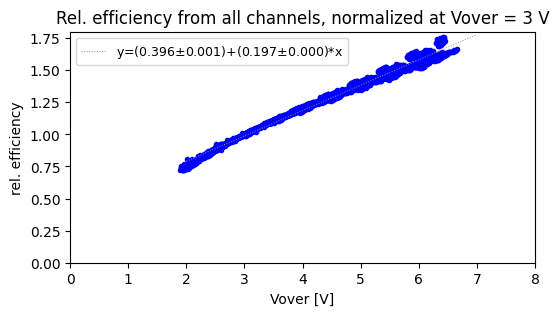

In [8]:
# relative efficiency vs. Vover are so similar across channels that they can be fit together
popt, pcov = curve_fit(func_lin, all_x, all_y)
slope = popt[0]
intercept = popt[1]
std_err = np.sqrt(pcov[0,0])
intercept_stderr = np.sqrt(pcov[1,1])
plt.figure(figsize = (6,3))
plt.plot(all_x, all_y, '.', color = 'b')
plt.plot(np.array([0.5*x for x in range(4, 15)]), slope * np.array([0.5*x for x in range(4, 15)]) + intercept, ':', color = '#929591', linewidth=0.7, 
         label='y=(%.3f$\pm$%.3f)+(%.3f$\pm$%.3f)*x'%(intercept, intercept_stderr, slope, std_err))
plt.title("Rel. efficiency from all channels, normalized at Vover = 3 V")
plt.legend(fontsize=9)
plt.xlabel('Vover [V]')
plt.ylabel('rel. efficiency')
plt.gca().set_xlim(0., 8.)
plt.gca().set_ylim(0., 1.8)
plt.show()

Previous 22.9%/V was calculated for Vset = 54 V, or Vover = 2.5 V. If we renormalize the fitting line above to have y = 1 at Vover = 2.5 V, the slope would be 0.19/(0.432+0.19*2.5) = 20.9%/V. This is not a big difference from the previous result.
We thought we would see ~1/4 or 1/3 overestimation? Is this result consistent? (normalization scheme in intermediate steps in previous analysis? rerun previous analysis uisng new method?)

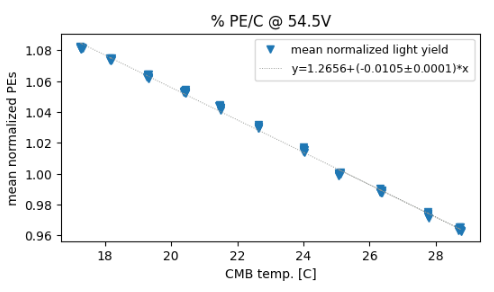

Back to the monitoring CMB. As each increasing degC of temperature is 55.4mV increase in Vbd, with 25 degC 54.5V at roughly 3V Vover, 17~28.7 degC correspond to 3.44V Vover to 2.80V Vover, or light yield of 1.086 to 0.964 => -1.05%/C is mostly SiPM effect, not LED.
The previous analysis -1.267%/C @ 54V converts to -1.22%/C. Some influence from LED, but not as huge as once thought. LED generates heat too, hard to determine the actual temperature change on it. 

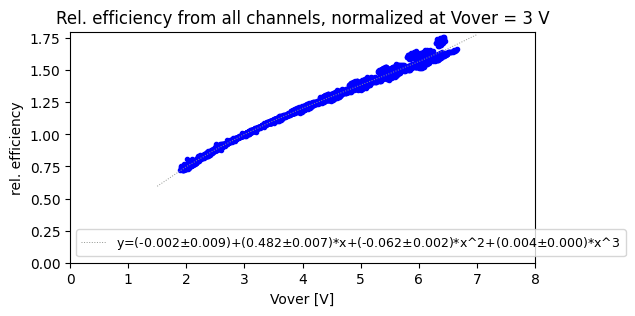

In [9]:
# relative efficiency vs. Vover are so similar across channels that they can be fit together
popt, pcov = curve_fit(func_cubic, all_x, all_y)
a = popt[0]
b = popt[1]
c = popt[2]
d = popt[3]
a_err = np.sqrt(pcov[0,0])
b_err = np.sqrt(pcov[1,1])
c_err = np.sqrt(pcov[2,2])
d_err = np.sqrt(pcov[3,3])
def tfunc(x):
    return a*x*x*x+b*x*x+c*x+d
plt.figure(figsize = (6,3))
plt.plot(all_x, all_y, '.', color = 'b')
dotx = np.array([0.5*x for x in range(3, 15)])
plt.plot(dotx, 
         np.apply_along_axis(tfunc, 0, dotx), ':', color = '#929591', linewidth=0.7, 
         label='y=(%.3f$\pm$%.3f)+(%.3f$\pm$%.3f)*x+(%.3f$\pm$%.3f)*x^2+(%.3f$\pm$%.3f)*x^3'%(d, d_err, c, c_err, b, b_err, a, a_err))
plt.title("Rel. efficiency from all channels, normalized at Vover = 3 V")
plt.legend(fontsize=9)
plt.xlabel('Vover [V]')
plt.ylabel('rel. efficiency')
plt.gca().set_xlim(0., 8.)
plt.gca().set_ylim(0., 1.8)
plt.show()

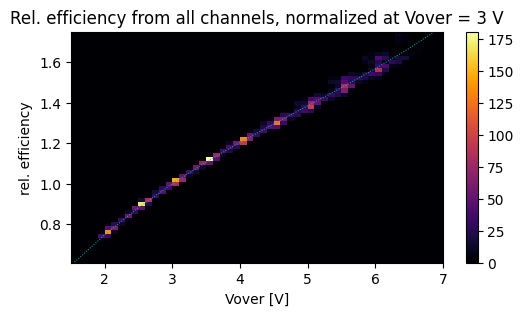

In [10]:
nx = 55 # 1.5-7V
xwidth = (7.-1.5)/55.
ny = 57 # 0.61-1.75
ywidth = (1.75-0.61)/57.

fig, ax = plt.subplots(figsize = (6,3))
hist = ax.hist2d(all_x, all_y, bins = [[xwidth*i+1.5 for i in range(nx+1)], [ywidth*i+0.61 for i in range(ny+1)]], cmap='inferno')
ax.plot(dotx, 
        np.apply_along_axis(tfunc, 0, dotx), ':', color = 'c', linewidth=0.7, 
        label='y=(%.3f$\pm$%.3f)+(%.3f$\pm$%.3f)*x+(%.3f$\pm$%.3f)*x^2+(%.3f$\pm$%.3f)*x^3'%(d, d_err, c, c_err, b, b_err, a, a_err))
plt.colorbar(hist[3], ax=ax, location='right')
plt.title("Rel. efficiency from all channels, normalized at Vover = 3 V")
plt.xlabel('Vover [V]')
plt.ylabel('rel. efficiency')
plt.gca().set_xlim(1.5, 7.)
plt.gca().set_ylim(0.61, 1.75)
plt.show()

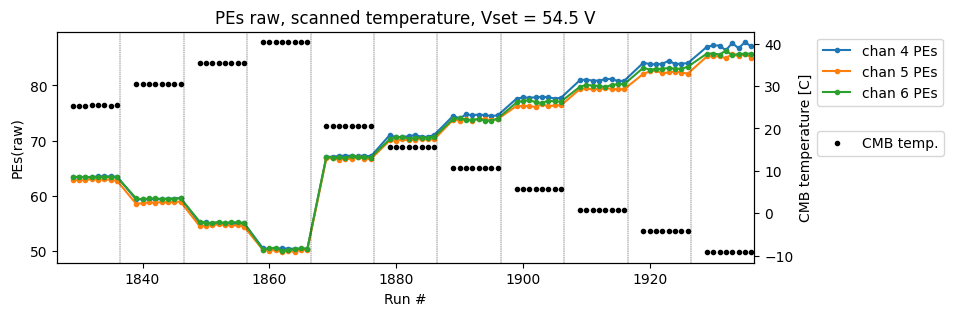

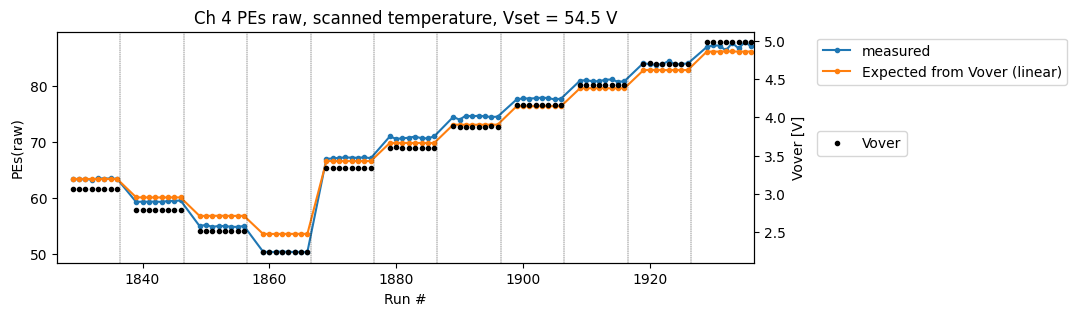

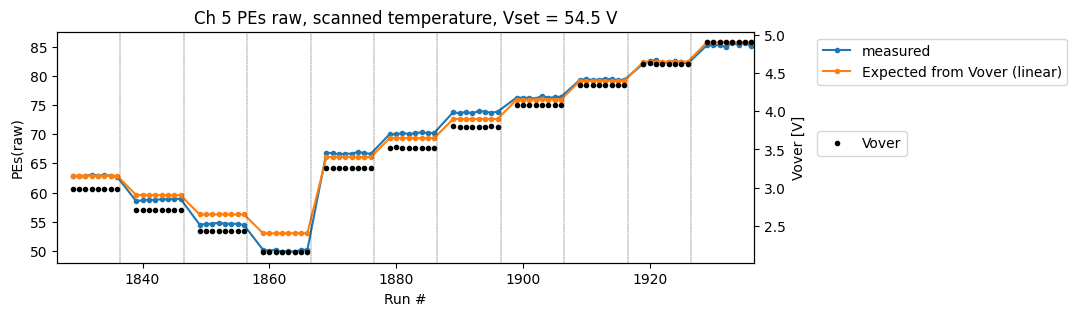

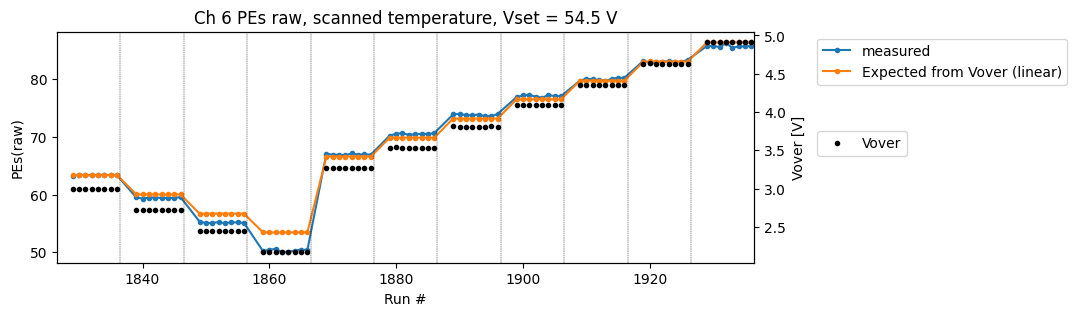

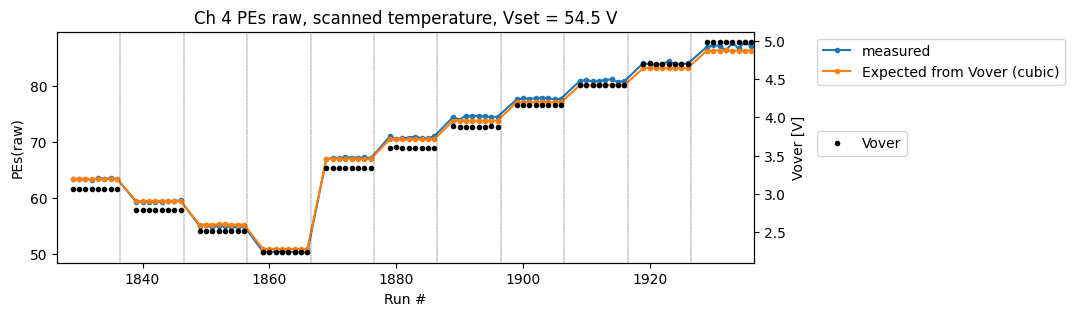

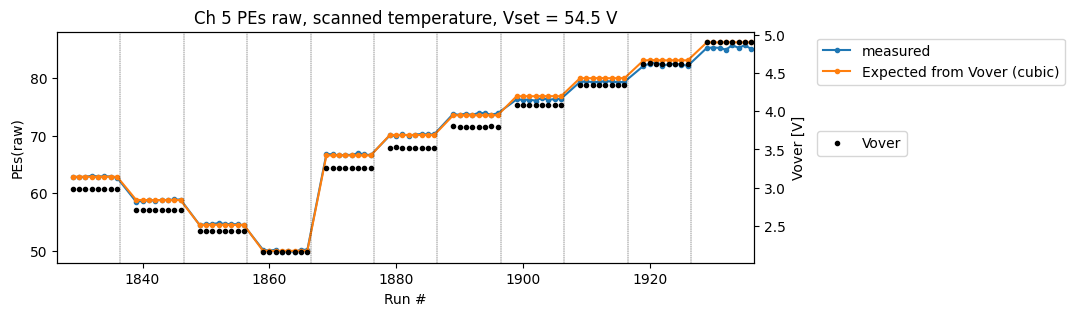

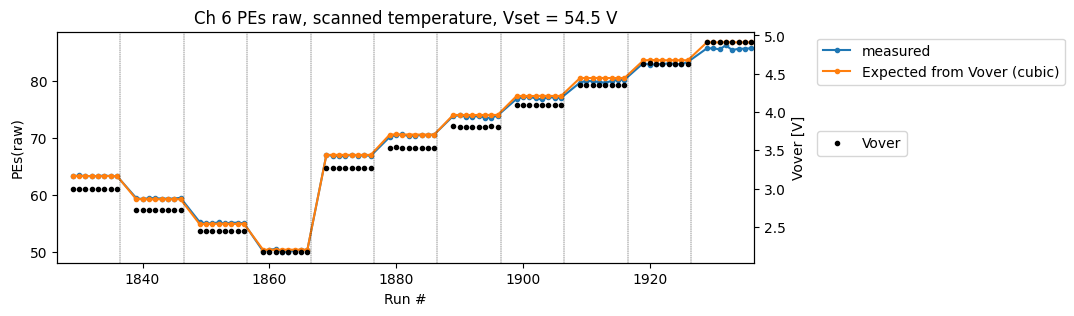

In [11]:
## verify channel 4-7

from __future__ import print_function
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pandas as pd
import pickle
from scipy.optimize import curve_fit
from scipy import stats

topdir = os.path.dirname(os.path.abspath("__file__"))
analysis_dir = os.path.join(topdir,"analysis_root_files")
data_pklname = os.path.join(analysis_dir,"tempScanSiDetRun2.pkl")
SPE_pklname = os.path.join(analysis_dir,"tempScanSiDetRun2SPE.pkl")

with open(data_pklname, 'rb') as f:
    df = pickle.load(f)
df = df.query("VoverN > 2.0").reset_index()

with open(SPE_pklname, 'rb') as f:
    df_SPE_clean = pickle.load(f)
    df_54V_Temp = pickle.load(f)
    df_55V_Temp = pickle.load(f)
    df_Vbd = pickle.load(f)

runs = df['run'].unique()
runs = np.sort(runs)
FEBs = df['FEB'].unique()
FEBs = np.sort(FEBs)
tempSetups = df['tempSetup'].unique()
tempSetups = np.sort(tempSetups)

Vbd_dict = {'4':51.69, '5':51.77, '6':51.76} #NIU @ 30degC

Vover = []
df_checkPEs = df.query("ch < 7 & ch > 3").reset_index(drop=True)
for index, row in df_checkPEs.iterrows():
    tChan = row['ch']
    VbdPerC = 0.0554
    tTemp = row['CMBtemp']
    tVppN = 54.5
    tVbd = Vbd_dict[str(tChan)] + VbdPerC* (tTemp-30.)
    tVover = tVppN - tVbd
    Vover.append(tVover)
# print(Vover)
df_checkPEs.loc[:, 'Vover'] = np.array(Vover)

PEfactor_lin = {} # @ 3V Vover
PEfactor_cubic = {} # @ 3V Vover
for chan in range(4,7):
    df_ = df_checkPEs.query("ch == %i & tempSetup == 25"%chan).reset_index(drop=True)
    PEfactor_lin.update({str(chan):np.mean(df_['PEs'])/(np.mean(df_['Vover'])*0.190+0.432)})
    PEfactor_cubic.update({str(chan):np.mean(df_['PEs'])/(tfunc(np.mean(df_['Vover'])))})

PEsExpected_lin = []
PEsExpected_cubic = []
for index, row in df_checkPEs.iterrows():
    tChan = row['ch']
    PEsExpected_lin.append(PEfactor_lin[str(tChan)]*(row['Vover']*0.190+0.432))
    PEsExpected_cubic.append(PEfactor_cubic[str(tChan)]*(tfunc(row['Vover'])))
# print(PEsExpected)
df_checkPEs.loc[:, 'PEsExpected_lin'] = np.array(PEsExpected_lin)
df_checkPEs.loc[:, 'PEsExpected_cubic'] = np.array(PEsExpected_cubic)

plt.figure(figsize = (9,3))
for chan in range(4,7):
    df_ = df_checkPEs.query('ch == %i'%chan)
    plt.plot(df_['run'], df_['PEs'],'.-',
             label='chan %i PEs'%chan)
plt.title("PEs raw, scanned temperature, Vset = 54.5 V")
plt.xlabel("Run #")
plt.ylabel("PEs(raw)")
plt.gca().set_xlim(np.min(runs)-2.5, np.max(runs)+0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1.08, 1.0))
ax2 = plt.gca().twinx()
ax2.plot(df_['run'], df_['CMBtemp'],'.', color='k', linestyle='none', label='CMB temp.')
ax2.set_ylabel("CMB temperature [C]")
plt.legend(loc='upper left', bbox_to_anchor=(1.08, 0.6))
for iTemp in range(11):
    plt.axvline(x=np.min(runs)+10*iTemp-2.5, color='k', linestyle='--', linewidth=0.3)
plt.show()

for chan in range(4,7):
    plt.figure(figsize = (9,3))
    df_ = df_checkPEs.query('ch == %i'%chan)
    plt.plot(df_['run'], df_['PEs'],'.-', label='measured')
    plt.plot(df_['run'], df_['PEsExpected_lin'],'.-', label='Expected from Vover (linear)')
    plt.title("Ch %i PEs raw, scanned temperature, Vset = 54.5 V"%chan)
    plt.xlabel("Run #")
    plt.ylabel("PEs(raw)")
    plt.gca().set_xlim(np.min(runs)-2.5, np.max(runs)+0.5)
    plt.legend(loc='upper left', bbox_to_anchor=(1.08, 1.0))
    ax2 = plt.gca().twinx()
    ax2.plot(df_['run'], df_['Vover'],'.', color='k', linestyle='none', label='Vover')
    ax2.set_ylabel("Vover [V]")
    plt.legend(loc='upper left', bbox_to_anchor=(1.08, 0.6))
    for iTemp in range(11):
        plt.axvline(x=np.min(runs)+10*iTemp-2.5, color='k', linestyle='--', linewidth=0.3)
    plt.show()

for chan in range(4,7):
    plt.figure(figsize = (9,3))
    df_ = df_checkPEs.query('ch == %i'%chan)
    plt.plot(df_['run'], df_['PEs'],'.-', label='measured')
    plt.plot(df_['run'], df_['PEsExpected_cubic'],'.-', label='Expected from Vover (cubic)')
    plt.title("Ch %i PEs raw, scanned temperature, Vset = 54.5 V"%chan)
    plt.xlabel("Run #")
    plt.ylabel("PEs(raw)")
    plt.gca().set_xlim(np.min(runs)-2.5, np.max(runs)+0.5)
    plt.legend(loc='upper left', bbox_to_anchor=(1.08, 1.0))
    ax2 = plt.gca().twinx()
    ax2.plot(df_['run'], df_['Vover'],'.', color='k', linestyle='none', label='Vover')
    ax2.set_ylabel("Vover [V]")
    plt.legend(loc='upper left', bbox_to_anchor=(1.08, 0.6))
    for iTemp in range(11):
        plt.axvline(x=np.min(runs)+10*iTemp-2.5, color='k', linestyle='--', linewidth=0.3)
    plt.show()
    